In [39]:
import nltk
import string
import PyPDF2
import os
import spacy
import string
import numpy as np

nlp = spacy.load('en_core_web_sm')

import matplotlib.pyplot as plt
from collections import Counter

from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd

from gensim import corpora
from gensim.models.ldamodel import LdaModel
from gensim.models import Phrases
from gensim.models.phrases import Phraser

from wordcloud import WordCloud
import pandas as pd


#### Uploading reports

In [40]:
#Loop that goes through each of the reports in the 'reports' folder, and turns them into strings, and removes the line breaks.

pdf_folder = 'reports'
pdf_texts = {}

# Loop through all PDFs
for filename in os.listdir(pdf_folder):
    if filename.endswith('.pdf'):
        report_name = filename.replace('.pdf', '').lower()
        with open(os.path.join(pdf_folder, filename), 'rb') as file:
            reader = PyPDF2.PdfReader(file)
            text = ""
            for page in reader.pages:
                content = page.extract_text()
                if content:
                    text += content + "\n"
            pdf_texts[report_name] = text

In [41]:
ubs24 = pdf_texts['ubs_24']
ubs23 = pdf_texts['ubs_23']
pwc24 = pdf_texts['pwc_24']
pwc23 = pdf_texts['pwc_23']
citi24 = pdf_texts['citi_24']
citi23 = pdf_texts['citi_23']
campden24 = pdf_texts['campden_24']
campden23 = pdf_texts['campden_23']

#### Cleaning the text

Creating a loop function that cleans the text, so i can go through each of the reports 

In [42]:
def clean_text_spacy(text):
    # Process the text with spaCy
    doc = nlp(text)

    # Remove punctuation, stop words, and non-alphabetic tokens
    cleaned_tokens = [
        token.text.lower() for token in doc if token.text not in string.punctuation and not token.is_stop and token.is_alpha
    ]

    # Join the tokens back into a single string
    cleaned_text = ' '.join(cleaned_tokens)

    return cleaned_text

#### Tokenising
Tokenising both by words and by sentences so that I can do different analysis 
Start with just doing words...

In [43]:
nlp = spacy.load("en_core_web_sm")

def get_word_tokens(text):
    doc = nlp(text)
    tokens = [token.text for token in doc if not token.is_space]
    return tokens

#### Lemmatising

In [44]:
def lemmatize_words(word_tokens):
    lemmatized_words = []
    for word in word_tokens:
        # Process each word with spaCy
        doc = nlp(word)

        # Lemmatize the word
        lemmatized_word = doc[0].lemma_

        lemmatized_words.append(lemmatized_word)

    return lemmatized_words

In [45]:
ubs24_clean = lemmatize_words(get_word_tokens(clean_text_spacy(ubs24)))
ubs23_clean = lemmatize_words(get_word_tokens(clean_text_spacy(ubs23)))
pwc24_clean = lemmatize_words(get_word_tokens(clean_text_spacy(pwc24)))
pwc23_clean = lemmatize_words(get_word_tokens(clean_text_spacy(pwc23)))
citi24_clean = lemmatize_words(get_word_tokens(clean_text_spacy(citi24)))
citi23_clean = lemmatize_words(get_word_tokens(clean_text_spacy(citi23)))
campden24_clean = lemmatize_words(get_word_tokens(clean_text_spacy(campden24)))
campden23_clean = lemmatize_words(get_word_tokens(clean_text_spacy(campden23)))

#### EDA

In [46]:
reports = {
    'ubs24': ubs24_clean,
    'ubs23': ubs23_clean,
    'pwc24': pwc24_clean,
    'pwc23': pwc23_clean,
    'citi24': citi24_clean,
    'citi23': citi23_clean,
    'campden24': campden24_clean,
    'campden23': campden23_clean
}

In [47]:
report_frequencies = {name: Counter(tokens) for name, tokens in reports.items()}


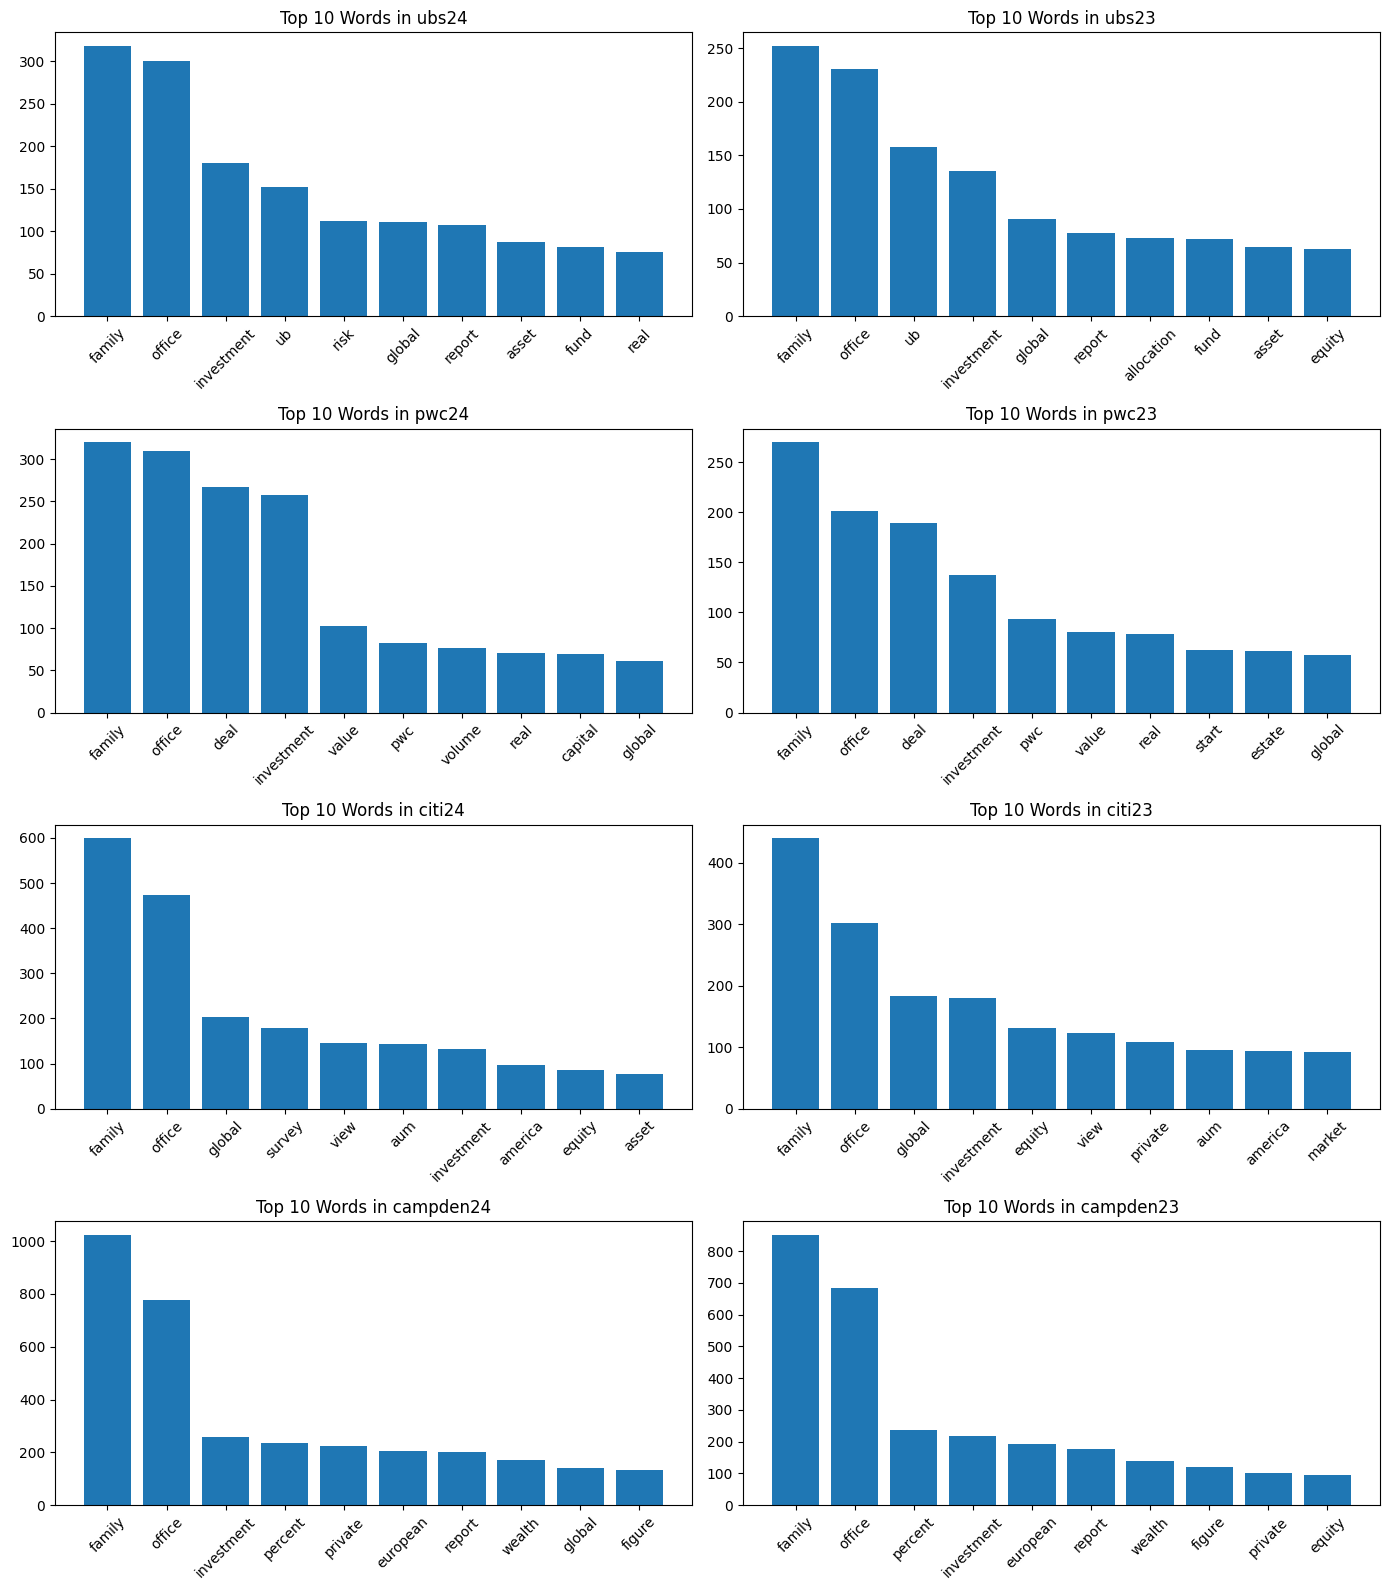

In [48]:
num_reports = len(report_frequencies)
cols = 2  # e.g. 2 columns
rows = (num_reports + 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(14, rows * 4))
axes = axes.flatten()

for idx, (name, freq) in enumerate(report_frequencies.items()):
    common = freq.most_common(10)
    words, counts = zip(*common)
    
    ax = axes[idx]
    ax.bar(words, counts)
    ax.set_title(f"Top 10 Words in {name}")
    ax.tick_params(axis='x', rotation=45)

# Hide empty subplots if any
for i in range(idx + 1, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()


In [49]:
keywords = ['sustainable', 'impact', 'sustainability', 'environmental', 'philanthropy', 'philanthropic', 'climate', 'governance']

for name, freq in report_frequencies.items():
    print(f"\n{name}")
    for word in keywords:
        print(f"  {word}: {freq[word]}")


ubs24
  sustainable: 2
  impact: 21
  sustainability: 21
  environmental: 1
  philanthropy: 5
  philanthropic: 1
  climate: 19
  governance: 7

ubs23
  sustainable: 4
  impact: 4
  sustainability: 1
  environmental: 1
  philanthropy: 2
  philanthropic: 0
  climate: 0
  governance: 9

pwc24
  sustainable: 13
  impact: 48
  sustainability: 6
  environmental: 3
  philanthropy: 0
  philanthropic: 0
  climate: 7
  governance: 0

pwc23
  sustainable: 3
  impact: 3
  sustainability: 1
  environmental: 1
  philanthropy: 0
  philanthropic: 0
  climate: 2
  governance: 2

citi24
  sustainable: 19
  impact: 7
  sustainability: 4
  environmental: 8
  philanthropy: 7
  philanthropic: 17
  climate: 2
  governance: 27

citi23
  sustainable: 37
  impact: 16
  sustainability: 8
  environmental: 4
  philanthropy: 26
  philanthropic: 24
  climate: 6
  governance: 8

campden24
  sustainable: 5
  impact: 18
  sustainability: 4
  environmental: 8
  philanthropy: 24
  philanthropic: 12
  climate: 6
  govern

In [50]:
#plot keyword counts over time
reports_2023 = ['ubs23', 'pwc23', 'citi23', 'campden23']
reports_2024 = ['ubs24', 'pwc24', 'citi24', 'campden24']

# Define keywords
keywords = ['sustainable', 'impact', 'sustainability', 'environmental', 
            'philanthropy', 'philanthropic', 'climate', 'governance']

# Count keyword appearances across reports in each year
def count_keywords(reports, keyword_list):
    counts = {kw: 0 for kw in keyword_list}
    for name in reports:
        freq = report_frequencies.get(name, {})
        for kw in keyword_list:
            counts[kw] += freq.get(kw, 0)
    return counts

counts_2023 = count_keywords(reports_2023, keywords)
counts_2024 = count_keywords(reports_2024, keywords)

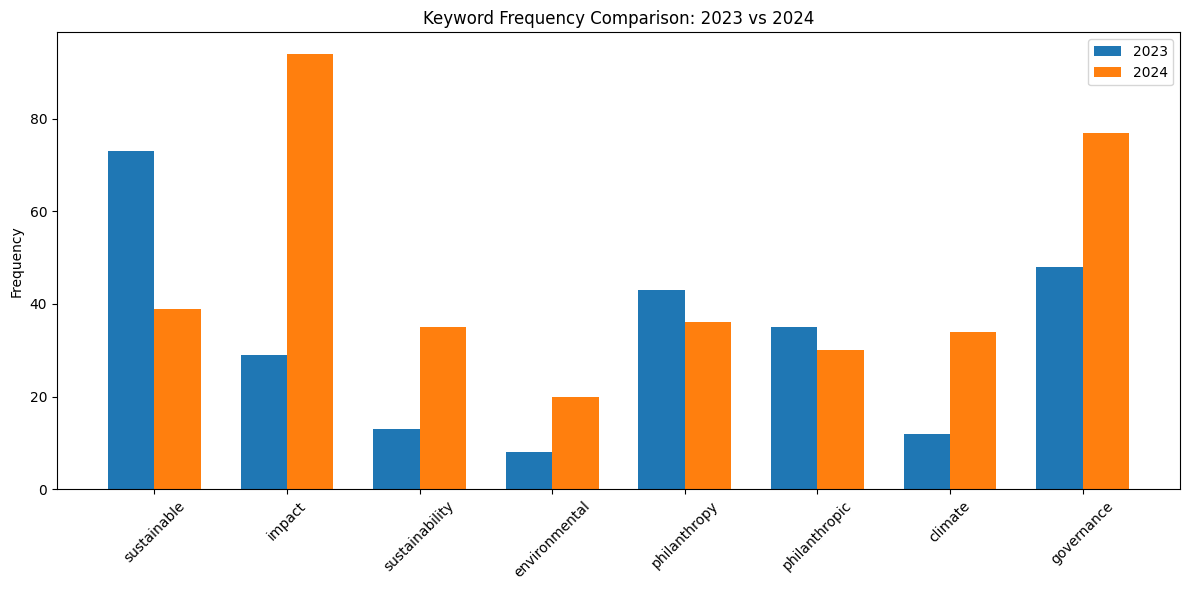

In [51]:
labels = keywords
x = np.arange(len(labels))  # label locations
width = 0.35  # width of bars

fig, ax = plt.subplots(figsize=(12, 6))
bar1 = ax.bar(x - width/2, [counts_2023[kw] for kw in labels], width, label='2023')
bar2 = ax.bar(x + width/2, [counts_2024[kw] for kw in labels], width, label='2024')

# Add labels and formatting
ax.set_ylabel('Frequency')
ax.set_title('Keyword Frequency Comparison: 2023 vs 2024')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45)
ax.legend()
plt.tight_layout()
plt.show()

#### N-Gram Analysis

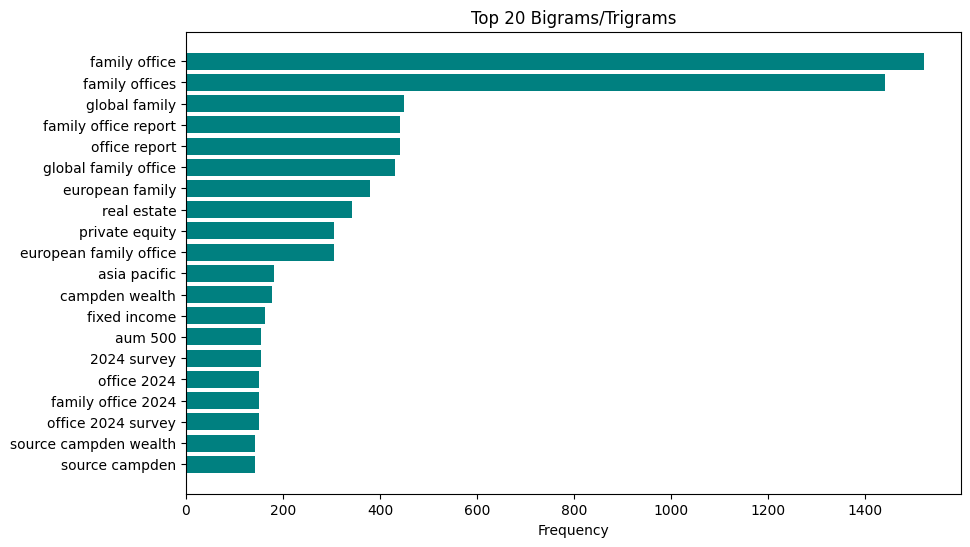

                         ngram  count
47034            family office   1521
47346           family offices   1441
53210            global family    450
47274     family office report    442
75232            office report    442
53214     global family office    431
44069          european family    380
88804              real estate    342
85746           private equity    306
44070   european family office    306
21952             asia pacific    181
27366           campden wealth    178
49824             fixed income    164
23144                  aum 500    154
5674               2024 survey    154
74480              office 2024    151
47042       family office 2024    151
74482       office 2024 survey    150
100107   source campden wealth    142
100106          source campden    142


In [52]:
documents = [ubs24, ubs23, pwc24, pwc23, citi24, citi23, campden24, campden23]

# Create a bigram/trigram vectorizer
vectorizer = CountVectorizer(ngram_range=(2, 3), stop_words='english')
X = vectorizer.fit_transform(documents)

# Sum up the counts of each bigram
bigrams = vectorizer.get_feature_names_out()
counts = X.toarray().sum(axis=0)

# Create a DataFrame for easy viewing
bigram_freq = pd.DataFrame({'ngram': bigrams, 'count': counts})
bigram_freq = bigram_freq.sort_values(by='count', ascending=False)

# Plot the top 20 bigrams
top_bigrams = bigram_freq.head(20)

plt.figure(figsize=(10, 6))
plt.barh(top_bigrams['ngram'], top_bigrams['count'], color='teal')
plt.xlabel('Frequency')
plt.title('Top 20 Bigrams/Trigrams')
plt.gca().invert_yaxis()  # To display the highest counts at the top
plt.show()

# Show top 20 bigrams/trigrams
print(bigram_freq.head(20))

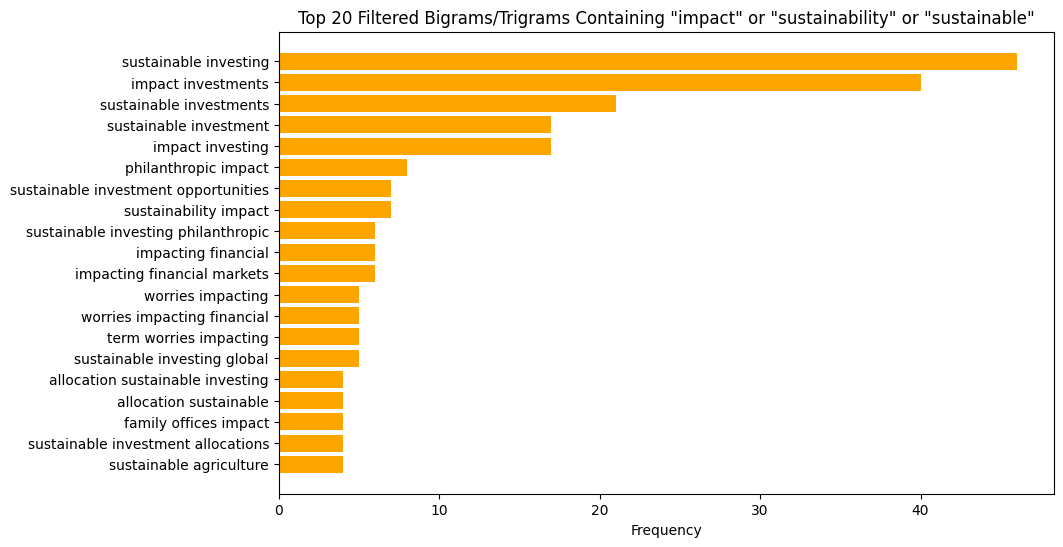

                                       ngram  count
103898                 sustainable investing     46
57215                     impact investments     40
103938               sustainable investments     21
103931                sustainable investment     17
57195                       impact investing     17
82201                   philanthropic impact      8
103934  sustainable investment opportunities      7
103823                 sustainability impact      7
103921   sustainable investing philanthropic      6
57303                    impacting financial      6
57304            impacting financial markets      6
112512                     worries impacting      5
112513           worries impacting financial      5
105489                term worries impacting      5
103912          sustainable investing global      5
19797       allocation sustainable investing      4
19796                 allocation sustainable      4
47639                  family offices impact      4
103932    su

In [57]:
# List of documents (cleaned text)
documents = [ubs24, ubs23, pwc24, pwc23, citi24, citi23, campden24, campden23]

# Create a bigram/trigram vectorizer
vectorizer = CountVectorizer(ngram_range=(2, 3), stop_words='english')
X = vectorizer.fit_transform(documents)

# Sum up the counts of each bigram
n_grams = vectorizer.get_feature_names_out()
counts = X.toarray().sum(axis=0)

# Create a DataFrame for easy viewing
ngram_freq = pd.DataFrame({'ngram': n_grams, 'count': counts})
ngram_freq = ngram_freq.sort_values(by='count', ascending=False)

# Filter for n-grams that contain 'filter' or 'sustainable'
keywords = ['impact', 'sustainable', 'sustainability']
filtered_ngrams = ngram_freq[ngram_freq['ngram'].str.contains('|'.join(keywords))]

top_20_filtered_ngrams = filtered_ngrams.head(20)

# Plot the top 20 filtered bigrams/trigrams
plt.figure(figsize=(10, 6))
plt.barh(top_20_filtered_ngrams['ngram'], top_20_filtered_ngrams['count'], color='orange')
plt.xlabel('Frequency')
plt.title('Top 20 Filtered Bigrams/Trigrams Containing "impact" or "sustainability" or "sustainable"')
plt.gca().invert_yaxis()  # To display the highest counts at the top
plt.show()

# Show the top 20 filtered n-grams
print(top_20_filtered_ngrams)